In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [5]:
df = pd.read_csv("../data/togo-dapaong_qc.csv", parse_dates=['Timestamp'])

In [6]:
# Summary stats
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-25 12:00:30.000000768,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
min,2021-10-25 00:01:00,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,2022-01-24 06:00:45,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2022-04-25 12:00:30,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,2022-07-25 18:00:15,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,2022-10-25 00:00:00,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN
std,NaN,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN


In [7]:
# Missing value report
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_report = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_report[missing_report['Missing %'] > 5]

,Missing Count,Missing %
Comments,525600,100.0


In [ ]:
# Columns of interest
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
z_scores = np.abs(stats.zscore(df[cols], nan_policy='omit'))
outliers = (z_scores > 3).any(axis=1)

# Flag and review outliers
df['is_outlier'] = outliers

# Clean: fill NA with median
for col in cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Optional: drop rows with outliers
# df = df[~df['is_outlier']]


In [10]:
df.to_csv("../data/togo_clean.csv", index=False)

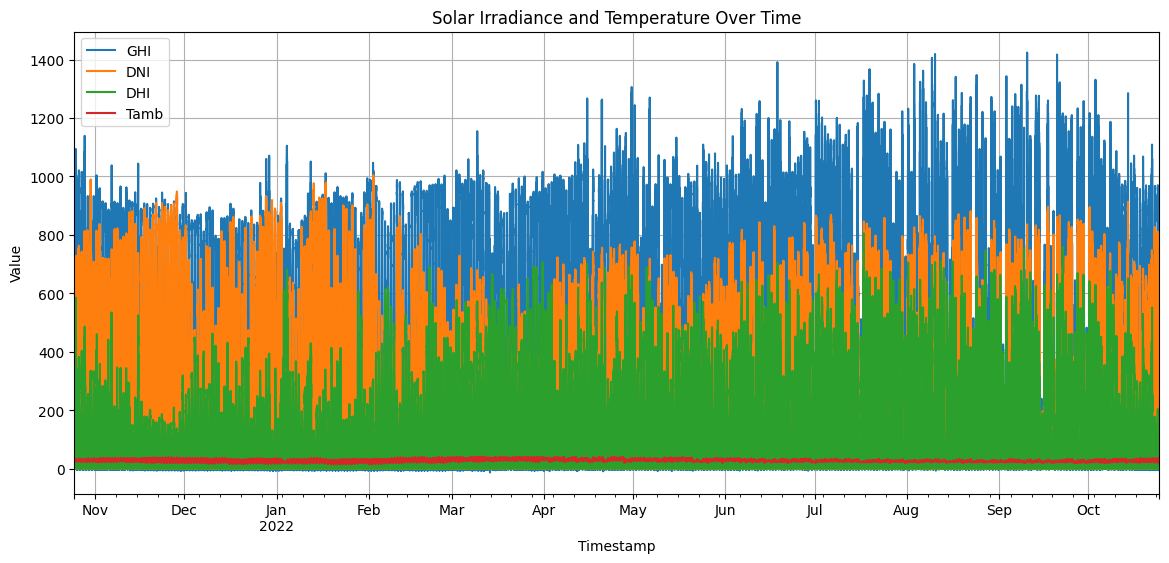

In [11]:
# Plot GHI, DNI, DHI, Tamb over time
time_cols = ['GHI', 'DNI', 'DHI', 'Tamb']
df.set_index('Timestamp')[time_cols].plot(figsize=(14,6))
plt.title("Solar Irradiance and Temperature Over Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()


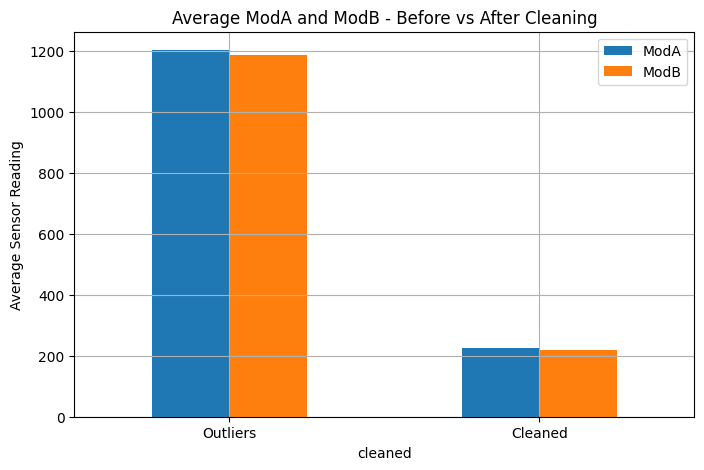

In [13]:
# Compare ModA and ModB before/after cleaning
from scipy.stats import zscore

# Calculate z-scores for selected columns
columns_to_check = ['ModA', 'ModB']  # You can include GHI, DNI, DHI, WS, WSgust, etc.
z_scores = df[columns_to_check].apply(zscore)

# Define outliers: any row with abs(Z) > 3 in any of the selected columns
df['is_outlier'] = (z_scores.abs() > 3).any(axis=1)

df['cleaned'] = ~df['is_outlier']
df.groupby('cleaned')[['ModA', 'ModB']].mean().plot(kind='bar', figsize=(8,5))
plt.title("Average ModA and ModB - Before vs After Cleaning")
plt.xticks([0, 1], ['Outliers', 'Cleaned'], rotation=0)
plt.ylabel("Average Sensor Reading")
plt.grid(True)
plt.show()


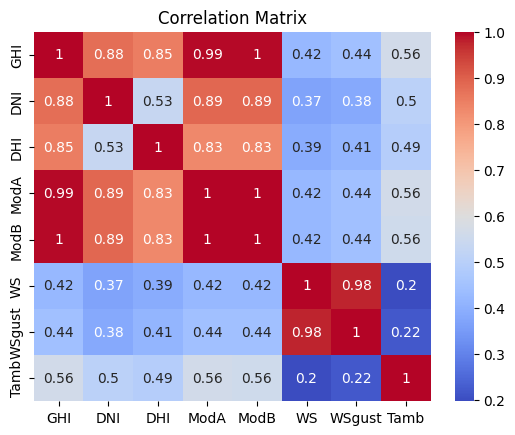

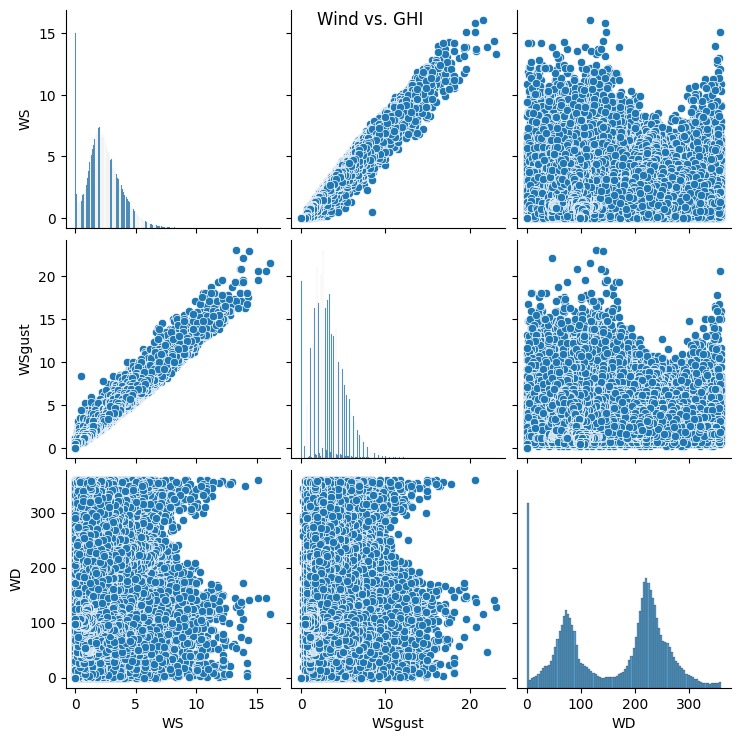

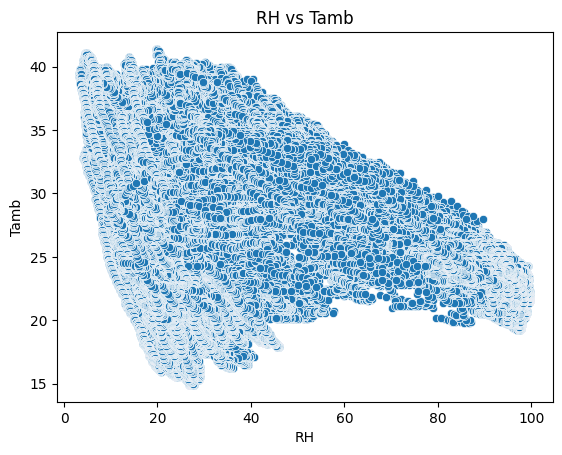

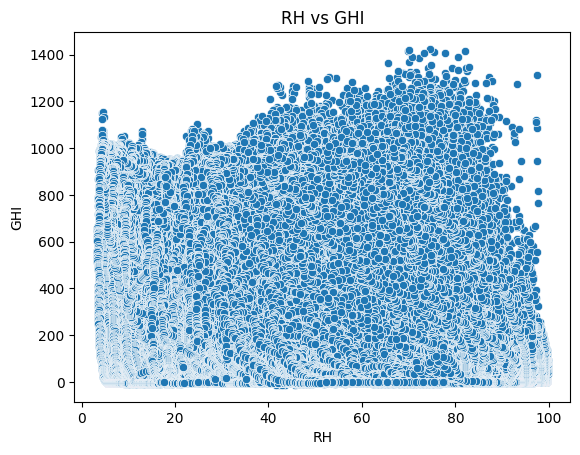

In [14]:
# Heatmap
sns.heatmap(df[cols + ['Tamb']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Scatter: WS, WSgust, WD vs GHI
sns.pairplot(df, vars=['WS', 'WSgust', 'WD'], y_vars=['GHI'])
plt.suptitle("Wind vs. GHI")
plt.show()

# RH vs Tamb & RH vs GHI
sns.scatterplot(data=df, x='RH', y='Tamb')
plt.title("RH vs Tamb")
plt.show()

sns.scatterplot(data=df, x='RH', y='GHI')
plt.title("RH vs GHI")
plt.show()


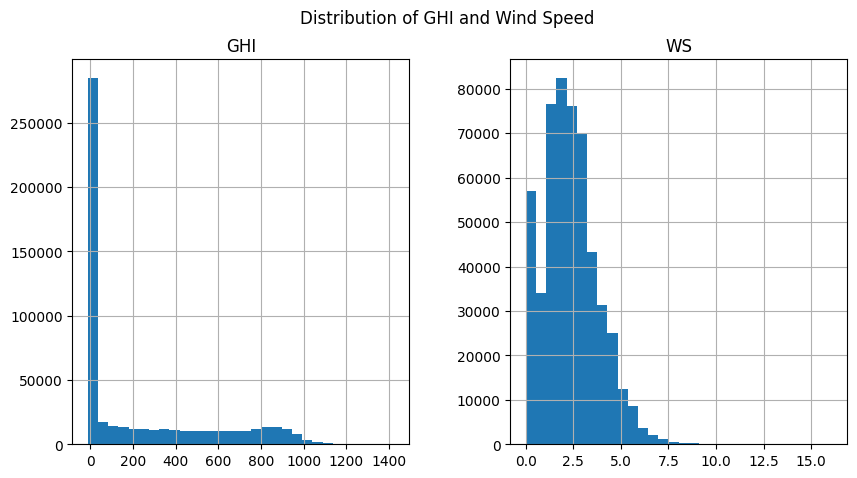

In [15]:
# Histogram of GHI and WS
df[['GHI', 'WS']].hist(bins=30, figsize=(10,5))
plt.suptitle("Distribution of GHI and Wind Speed")
plt.show()


In [ ]:
sns.scatterplot(data=df, x='RH', y='Tamb', hue='GHI', palette='coolwarm')
plt.title("RH vs Tamb colored by GHI")
plt.show()


In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['GHI'], df['Tamb'], s=df['RH'], alpha=0.5, c=df['BP'], cmap='viridis')
plt.xlabel("GHI")
plt.ylabel("Tamb")
plt.title("Bubble Chart: GHI vs Tamb (Size=RH, Color=BP)")
plt.colorbar(label='BP')
plt.grid(True)
plt.show()
